In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm


In [2]:
btc_data = yf.download("BTC-USD", auto_adjust=False)

# Extract Adjusted Close prices
btc_daily = btc_data['Adj Close']

# Resample to weekly (last closing price of each week)
btc_weekly = btc_daily.resample('W').last()

# Resample to monthly (last closing price of each month)
btc_monthly = btc_daily.resample('M').last()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Extract the date range from the BTC data
start_date = btc_daily.index.min().strftime('%Y-%m-%d')
end_date = btc_daily.index.max().strftime('%Y-%m-%d')

# Download the US T-bill rate for the same period
t_bill_data = yf.download('^IRX', start=start_date, end=end_date)
t_bill_adj_close = t_bill_data['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Reindex T-bill data to match Bitcoin dates
t_bill_adj_close_reindexed = t_bill_adj_close.reindex(btc_daily.index)

# Interpolate missing T-bill rates
t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')
t_bill_weekly = t_bill_daily.resample('W').last()
t_bill_monthly = t_bill_daily.resample('M').last()

In [5]:
t_bill_daily

Ticker,^IRX
Date,
2014-09-17,0.013000
2014-09-18,0.010000
2014-09-19,0.007000
2014-09-20,0.005667
2014-09-21,0.004333
...,...
2025-03-05,4.205000
2025-03-06,4.197000
2025-03-07,4.197000


In [6]:
combined_df = pd.concat([btc_daily, t_bill_daily], axis=1, join='outer')
combined_df.columns = ['BTC_Close', 'TBill_Close']

 
combined_df

,BTC_Close,TBill_Close
Date,,
2014-09-17,457.334015,0.013000
2014-09-18,424.440002,0.010000
2014-09-19,394.795990,0.007000
2014-09-20,408.903992,0.005667
2014-09-21,398.821014,0.004333
...,...,...
2025-03-05,90623.562500,4.205000
2025-03-06,89961.726562,4.197000
2025-03-07,86742.671875,4.197000


# CPPI

In [7]:
def cppi_strategy(start_date, end_date, multipliers, floor_fractions, initial_portfolio_value, frequency='daily'):
    btc_data = yf.download("BTC-USD", start=start_date, end=end_date, auto_adjust=True)
    t_bill_data = yf.download("^IRX", start=start_date, end=end_date)

    btc_prices = btc_data['Close'].astype(float)
    t_bill_rates = t_bill_data['Close'].astype(float)

    t_bill_adj_close_reindexed = t_bill_rates.reindex(btc_prices.index)

    t_bill_daily = t_bill_adj_close_reindexed.interpolate(method='linear')

    combined_df = pd.concat([btc_prices, t_bill_daily], axis=1, join='outer')
    combined_df.columns = ['BTC_Close', 'TBill_Close']
    combined_df.fillna(method='bfill', inplace=True)

    if frequency == 'weekly':
        combined_df = combined_df.resample('W').last()
    elif frequency == 'monthly':
        combined_df = combined_df.resample('M').last()
    elif frequency != 'daily':
        raise ValueError("Invalid frequency. Choose from 'daily', 'weekly', or 'monthly'.")

    if 'BTC_Close' not in combined_df or 'TBill_Close' not in combined_df:
        raise ValueError("combined_df must contain 'BTC_Close' and 'TBill_Close' columns.")

    results = {}

    for multiplier in multipliers:
        for floor_fraction in floor_fractions:
            basket_value = float(initial_portfolio_value)
            floor = float(basket_value * floor_fraction)
            
            risky_weights, riskless_weights, basket_values = [], [], []

            for i in range(1, len(combined_df)):
                if isinstance(basket_value, pd.Series):
                    basket_value = basket_value.iloc[0]
                
                cushion = np.maximum(basket_value - floor, 0) / basket_value
                risky_w = np.clip(multiplier * cushion, 0, 1)
                riskless_w = 1 - risky_w
                
                risky_return = (combined_df['BTC_Close'].iloc[i] - combined_df['BTC_Close'].iloc[i - 1]) / combined_df['BTC_Close'].iloc[i - 1]
                riskless_return = ((1 + combined_df['TBill_Close'].iloc[i] / 100) ** (1 / 52)) - 1
                
                portfolio_return = risky_w * risky_return + riskless_w * riskless_return
                basket_value *= (1 + portfolio_return)
                
                risky_weights.append(risky_w)
                riskless_weights.append(riskless_w)
                basket_values.append(float(basket_value))

            cppi_df = pd.DataFrame({
                'Basket Value': basket_values,
                'Risky Weights': risky_weights,
                'Risk-Free Weights': riskless_weights
            }, index=combined_df.index[1:])
            
            results[(multiplier, floor_fraction)] = cppi_df
    
    return results

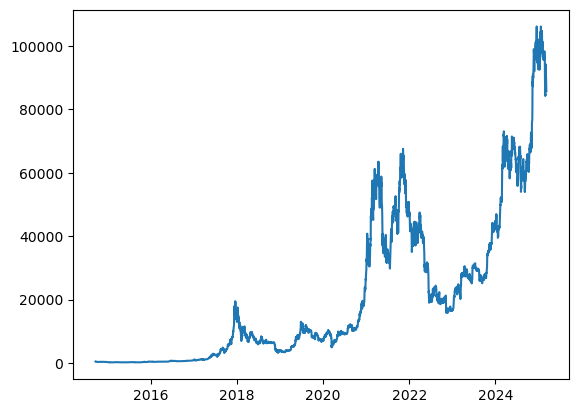

In [8]:
plt.plot(btc_daily)

# Flat market

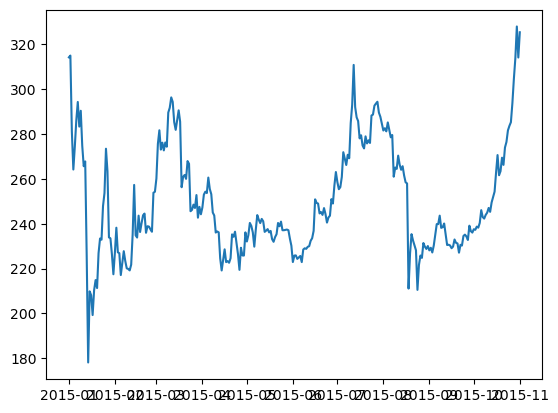

In [9]:
plt.plot(btc_daily.loc['2015-01-01':'2015-11-01'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


             Basket Value  Risky Weights  Risk-Free Weights
Date                                                       
2015-01-02  100149.618484       0.600000           0.400000
2015-01-03   93619.194625       0.605079           0.394921
2015-01-04   91547.960066       0.368266           0.631734
2015-01-05   92567.039392       0.286100           0.713900
2015-01-06   93859.173135       0.326986           0.673014


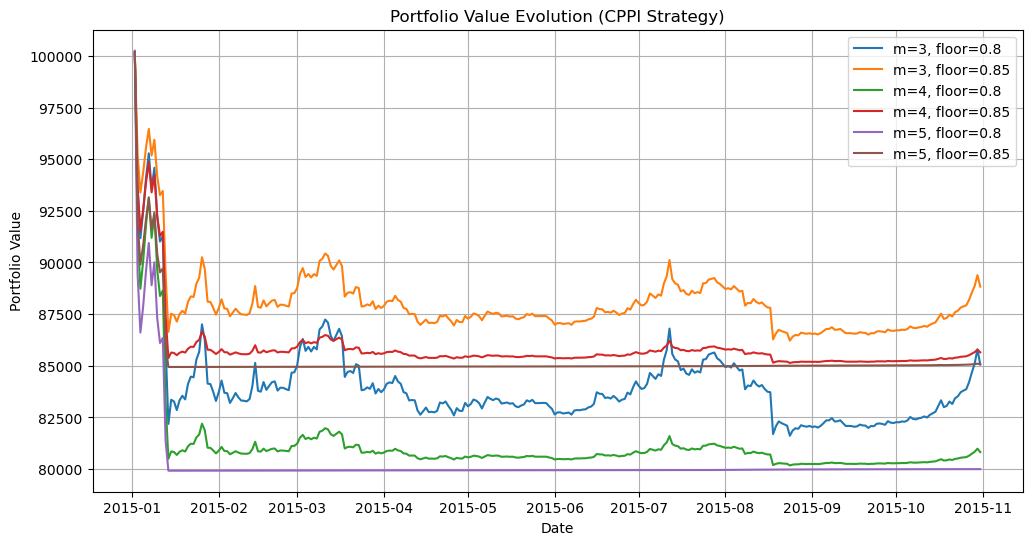

In [10]:
start_date = "2015-01-01"
end_date = "2015-11-01"
multipliers = [3, 4, 5]
floor_fractions = [0.8, 0.85]
initial_value = 100000
frequency = 'daily' 

results = cppi_strategy(start_date, end_date, multipliers, floor_fractions, initial_value, frequency)

selected_result = results[(4, 0.85)]
print(selected_result.head())

plt.figure(figsize=(12, 6))
for key, df in results.items():
    plt.plot(df.index, df['Basket Value'].astype(float), label=f"m={key[0]}, floor={key[1]}")

plt.title("Portfolio Value Evolution (CPPI Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()


# Bear market

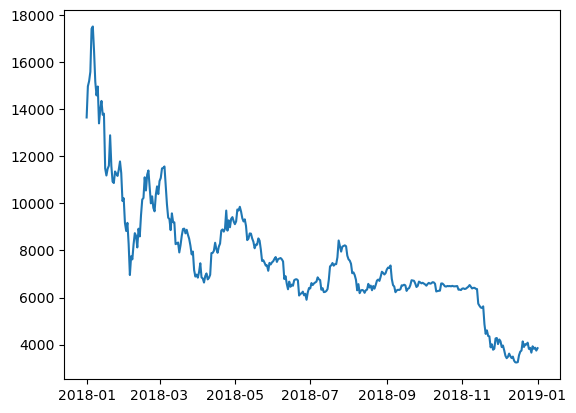

In [11]:
plt.plot(btc_daily.loc['2018-01-01':'2019-01-01'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


             Basket Value  Risky Weights  Risk-Free Weights
Date                                                       
2018-01-02  105831.192381       0.600000           0.400000
2018-01-03  107054.523629       0.787337           0.212663
2018-01-04  109370.384284       0.824048           0.175952
2018-01-05  120811.289681       0.891297           0.108703
2018-01-06  121487.103717       1.000000           0.000000


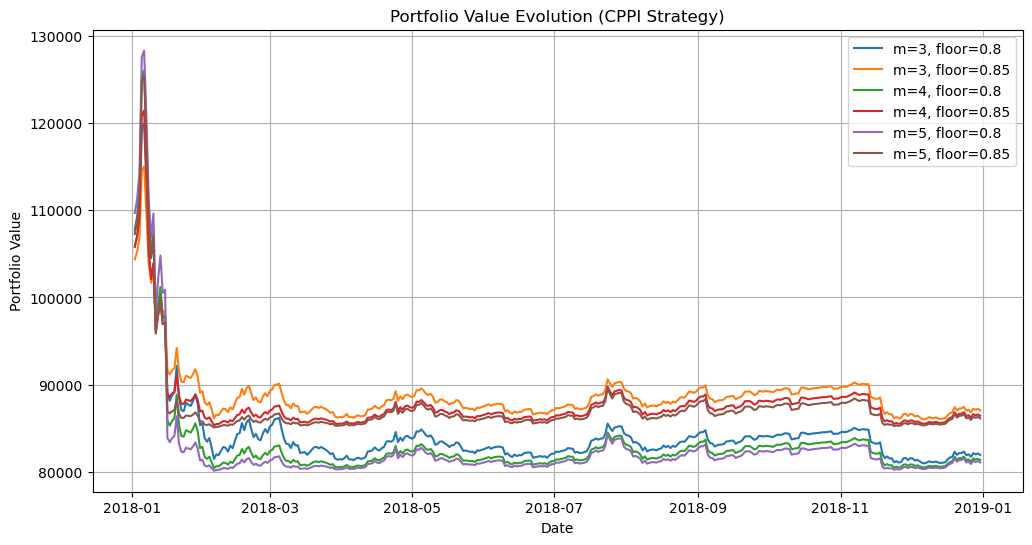

In [12]:
start_date = "2018-01-01"
end_date = "2019-01-01"
multipliers = [3, 4, 5]
floor_fractions = [0.8, 0.85]
initial_value = 100000
frequency = 'daily' 

results = cppi_strategy(start_date, end_date, multipliers, floor_fractions, initial_value, frequency)

selected_result = results[(4, 0.85)]
print(selected_result.head())

plt.figure(figsize=(12, 6))
for key, df in results.items():
    plt.plot(df.index, df['Basket Value'].astype(float), label=f"m={key[0]}, floor={key[1]}")

plt.title("Portfolio Value Evolution (CPPI Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()


# Bull market

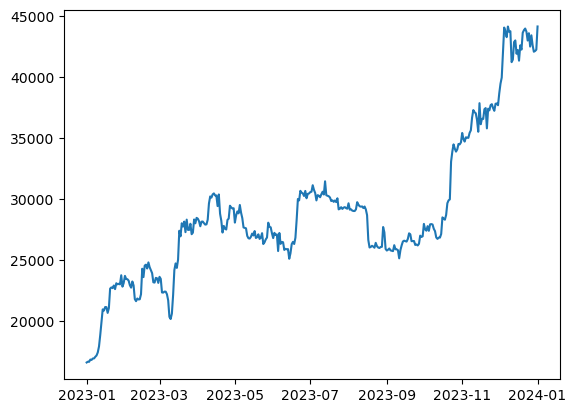

In [13]:
plt.plot(btc_daily.loc['2023-01-01':'2024-01-01'])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


             Basket Value  Risky Weights  Risk-Free Weights
Date                                                       
2023-01-02  100260.843506       0.600000           0.400000
2023-01-03  100260.776788       0.608846           0.391154
2023-01-04  100964.382194       0.608843           0.391157
2023-01-05  100895.434670       0.632476           0.367524
2023-01-06  101362.145388       0.630175           0.369825


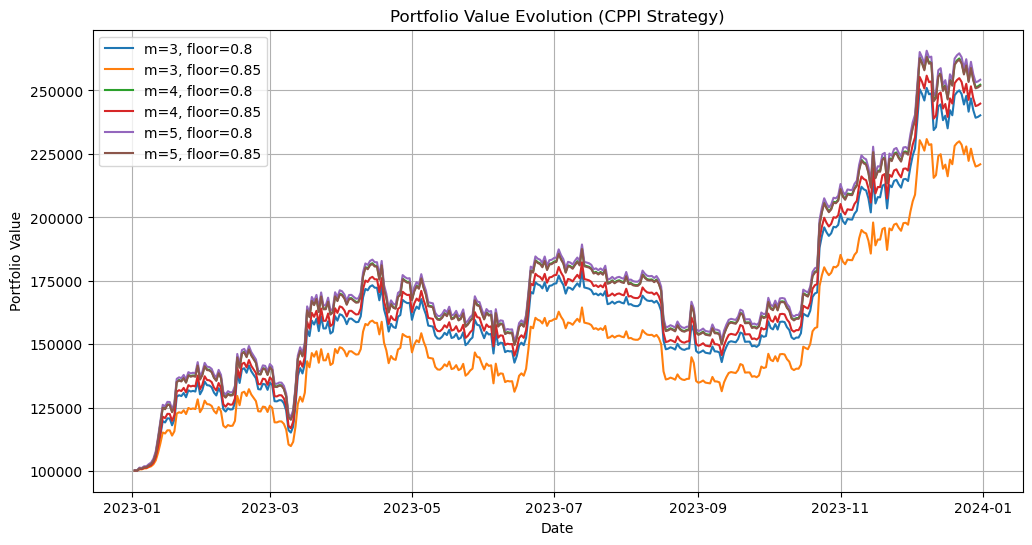

In [14]:
start_date = "2023-01-01"
end_date = "2024-01-01"
multipliers = [3, 4, 5]
floor_fractions = [0.8, 0.85]
initial_value = 100000
frequency = 'daily' 

results = cppi_strategy(start_date, end_date, multipliers, floor_fractions, initial_value, frequency)

selected_result = results[(4, 0.85)]
print(selected_result.head())

plt.figure(figsize=(12, 6))
for key, df in results.items():
    plt.plot(df.index, df['Basket Value'].astype(float), label=f"m={key[0]}, floor={key[1]}")

plt.title("Portfolio Value Evolution (CPPI Strategy)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid()
plt.show()

# OBPI

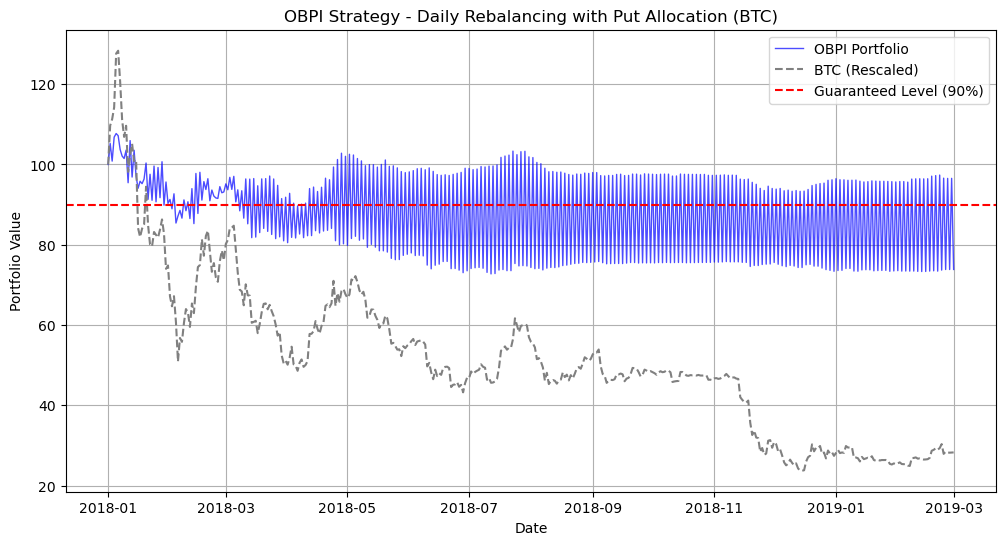

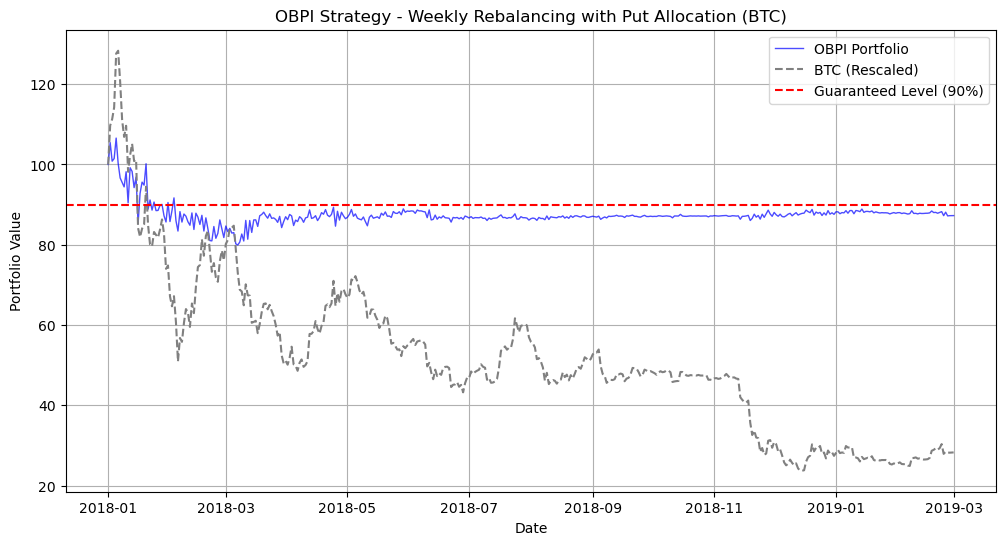

In [43]:
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt

# -------------------------
# Black-Scholes Put Price & Delta Calculation
# -------------------------
# -------------------------
# Black-Scholes Put Price & Delta Calculation
# -------------------------
def black_scholes_put(S, K, T, r, sigma):
    """ Calcule le prix et le delta du put selon Black-Scholes """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    put_price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    delta_put = si.norm.cdf(d1) - 1  # Delta d'un put

    return put_price, delta_put


# -------------------------
# OBPI Strategy Function with Rebalancing Frequency
# -------------------------
def obpi_strategy(data, start_date=None, end_date=None, 
                  initial_wealth=100, strike_fraction=0.9, 
                  volatility=2, maturity=1, 
                  rebalancing_frequency="daily"):
    """
    OBPI améliorée avec choix de la fréquence de rebalancement.
    
    - `data`: DataFrame contenant BTC_Close et TBill_Close
    - `start_date`, `end_date`: Période d'analyse
    - `initial_wealth`: Richesse initiale
    - `strike_fraction`: Fraction de protection (ex: 0.9 pour 90% de protection)
    - `volatility`: Volatilité implicite estimée
    - `maturity`: Temps de maturité du put (en années)
    - `rebalancing_frequency`: "daily", "weekly", ou "monthly"
    """

    # Filtrage des dates
    if start_date:
        data = data[data.index >= start_date]
    if end_date:
        data = data[data.index <= end_date]

    if data.empty:
        print("❌ Aucune donnée disponible pour la période spécifiée.")
        return None

    # Nettoyage des données
    data = data.dropna().copy()

    # Définir les dates de rebalancement en fonction de la fréquence
    if rebalancing_frequency == "daily":
        rebalancing_dates = data.index
    elif rebalancing_frequency == "weekly":
        rebalancing_dates = data.resample("W-MON").first().index  # Chaque lundi
    elif rebalancing_frequency == "monthly":
        rebalancing_dates = data.resample("M").first().index  # Début de chaque mois
    else:
        raise ValueError("⚠️ Fréquence de rebalancement invalide. Choisir 'daily', 'weekly' ou 'monthly'.")

    # Initialisation du portefeuille
    portfolio_value = initial_wealth
    strike_price = strike_fraction * data.iloc[0]["BTC_Close"] 
    safe_asset = initial_wealth
    risky_asset = 0  

    wealth_history = []
    risky_alloc_history = []
    
    for i in range(len(data)):
        S = data.iloc[i]["BTC_Close"]  
        r = data.iloc[i]["TBill_Close"] / 100  
        T = max(maturity - i / 252, 1/252)  # Réduction de la maturité

        # Vérifier si c'est un jour de rebalancement
        if data.index[i] in rebalancing_dates:
            # Calcul du prix du put et de son delta
            P_t, delta_p = black_scholes_put(S, strike_price, T, r, volatility)
            
            # Calcul de la proportion investie en BTC
            if P_t + S > 0:
                w_t = ((1 + delta_p) * S) / (P_t + S)
            else:
                w_t = 0  

            # **Correction** : Limite l'exposition max au risky asset pour éviter le crash total
            w_t = max(min(w_t, 1), 0.1)  # Minimum 10% en safe asset
            
            # Allocation dynamique
            risky_allocation = w_t * portfolio_value
            safe_allocation = portfolio_value - risky_allocation
        else:
            # Si ce n'est pas un jour de rebalancement, on conserve les allocations précédentes
            risky_allocation = risky_asset
            safe_allocation = safe_asset

        # Mise à jour de la richesse totale
        if i > 0:
            portfolio_value = risky_asset * (S / data.iloc[i-1]["BTC_Close"]) + safe_asset * np.exp(r / 252)
        
        # Stockage des données
        wealth_history.append(portfolio_value)
        risky_alloc_history.append(risky_allocation / portfolio_value)  # Stocke la proportion allouée au risky asset

        # Mise à jour des allocations
        risky_asset = risky_allocation
        safe_asset = safe_allocation

    # Convertir en DataFrame
    results = pd.DataFrame({"Date": data.index, "Portfolio_Value": wealth_history, "Risky_Allocation": risky_alloc_history})
    results.set_index("Date", inplace=True)

    # -------------------------
    # Plot des résultats
    # -------------------------
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results["Portfolio_Value"], label="OBPI Portfolio", linewidth=1, color="blue", alpha=0.7)
    plt.plot(data.index, data["BTC_Close"] / data.iloc[0]["BTC_Close"] * initial_wealth, 
             label="BTC (Rescaled)", linestyle="dashed", color="gray")
    plt.axhline(y=initial_wealth * strike_fraction, color='r', linestyle='--', label="Guaranteed Level (90%)")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.title(f"OBPI Strategy - {rebalancing_frequency.capitalize()} Rebalancing with Put Allocation (BTC)")
    plt.grid()
    plt.show()

    return results

# -------------------------
# Exécution avec choix de rebalancement
# -------------------------

results_low_vol = obpi_strategy(combined_df, start_date="2018-01-01", end_date="2019-03-01", 
                                volatility=2, maturity=1.0, rebalancing_frequency="daily")
results_high_vol = obpi_strategy(combined_df, start_date="2018-01-01", end_date="2019-03-01", 
                                 volatility=1, maturity=1, rebalancing_frequency="weekly")
